In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader


In [2]:
def hparameters_dict(N_EPOCHS=500,N_SAMPLES=10000,BATCH_SIZE=100,lr=1e-4):
    hp = { "N_EPOCHS":N_EPOCHS, 
            "N_SAMPLES":N_SAMPLES,
            "BATCH_SIZE":BATCH_SIZE,
            "lr":lr,
        }
    return hp

In [3]:
def f(a,**kwargs):
    hp = hparameters(**kwargs)
    print(N)

In [4]:
def train(encoder,decoder,q,p_x,**kwargs):
    hp = hparameters(**kwargs)
    x_samples = p_x.sample((N_SAMPLES,))[:,None]
    x_sorted,indices = x_samples.sort(dim=0)
    x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
    x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
    return

Text(0, 0.5, 'Encoding')

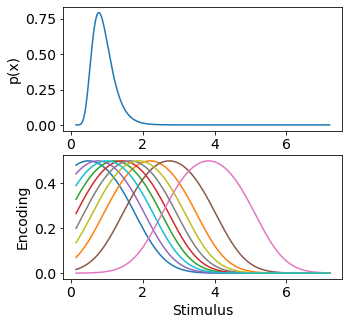

In [15]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.4,0.6]))
gs = torch.distributions.normal.Normal(torch.Tensor([-4,4]),torch.tensor([1,2]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(0,.5)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES = 10000
lr = 1e-4
BATCH_SIZE = 100
#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
#enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*(x_max-x_min)/(0.5*N))[None,:])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_fine,10**p_x.log_prob(x_fine).detach())
axs[0].set_xlabel("Stimulus")
axs[0].set_ylabel("p(x)")
#enc.As = torch.nn.Parameter(torch.ones(N)[None,:])
axs[1].plot(x_fine,torch.sigmoid(enc(x_fine)).detach())
axs[1].set_xlabel("Stimulus")
axs[1].set_ylabel("Encoding")
#axs2 = axs.twinx()


In [76]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
#lr = 1e-4
lVec,dVec,rVec,bVec = ([] for _ in range(4))
opt = torch.optim.Adam(params,lr)
#Scheduled Beta
bVec = [1*i/N_EPOCHS  if 1*i/N_EPOCHS<1 else 1 for i in range(N_EPOCHS)]
#bVec = [1/(1 + np.exp(-x/30 + 7)) for x in range(N_EPOCHS)]
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    beta = bVec[e]
    beta=1
    for x_ in x_data:
        rate = q(enc,x_)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =  distortion +beta*rate
        opt.zero_grad()
        loss.backward()
        opt.step()
        lav += distortion + rate
        dav += distortion
        rav += rate
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))
    #bVec.append(beta)
    print(f"Epoch: {e} || ELBO: {lVec[-1]}")


Epoch: 0 || ELBO: 0.7592961120605469
Epoch: 1 || ELBO: 0.7590593719482421
Epoch: 2 || ELBO: 0.7590247344970703
Epoch: 3 || ELBO: 0.7589839172363281
Epoch: 4 || ELBO: 0.7589409637451172
Epoch: 5 || ELBO: 0.7588993072509765
Epoch: 6 || ELBO: 0.7588579559326172
Epoch: 7 || ELBO: 0.7588143157958984
Epoch: 8 || ELBO: 0.7587702178955078
Epoch: 9 || ELBO: 0.7587274932861328
Epoch: 10 || ELBO: 0.7586803436279297
Epoch: 11 || ELBO: 0.7586384582519531
Epoch: 12 || ELBO: 0.7585965728759766
Epoch: 13 || ELBO: 0.7585556030273437
Epoch: 14 || ELBO: 0.7585150146484375
Epoch: 15 || ELBO: 0.7584739685058594
Epoch: 16 || ELBO: 0.7584359741210938
Epoch: 17 || ELBO: 0.7583936309814453
Epoch: 18 || ELBO: 0.7583555603027343
Epoch: 19 || ELBO: 0.7583186340332031
Epoch: 20 || ELBO: 0.7582806396484375
Epoch: 21 || ELBO: 0.7582425689697265
Epoch: 22 || ELBO: 0.7582069396972656
Epoch: 23 || ELBO: 0.7581687927246094
Epoch: 24 || ELBO: 0.7581314849853515
Epoch: 25 || ELBO: 0.758094711303711
Epoch: 26 || ELBO: 0.75

In [16]:
#Minimax training
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
#params = q.parameters()
#lr = 1e-4
lVec,dVec,rVec,bVec,CVec = ([] for _ in range(5))
opt = torch.optim.Adam(params,lr)
#Scheduled Beta
beta = 1
t = 0
for e in range(N_EPOCHS):
    lav = dav = rav = 0
    #beta=1
    for x_ in x_data:
        rate = q(enc,x_)
        #distortion = distortion_gaussian(x_,enc,dec,lat_samp = 50,tau=0.01)
        distortion = distortion_analytical(x_,enc,dec,q.r_all)
        #print(enc.log_sigmas.grad)
        loss =   rate + beta*(distortion+1.)
        opt.zero_grad()
        loss.backward()
        opt.step()
        C_ext = distortion.item()
        if t == 0:
            C_tma = distortion.item()
        else:
            C_tma = 0.99*CVec[-1] + 0.01*C_ext

        C_t = C_ext + (C_tma - C_ext)
        lav += distortion + rate
        dav += distortion
        rav += rate
        CVec.append(C_t)
        beta *= np.exp(1e-3*C_t)
        t +=1
        print(beta)
    lVec.append(lav.item()/len(x_data))
    rVec.append(rav.item()/len(x_data))
    dVec.append(dav.item()/len(x_data))
    bVec.append(1/beta)
    print(f"Epoch: {e} || ELBO: {lVec[-1]}")

1.0017429946226035
1.003488695414836
1.0052395033011348
1.006993947433091
1.0087519159703315
1.0105128823644962
1.01227581626906
1.0140415968360454
1.015809895630111
1.0175825616459855
1.019357530838697
1.0211359153103283
1.0229169659021038
1.0247006069774152
1.0264864916990264
1.0282763045122274
1.0300687466970897
1.0318639190282268
1.0336614048619295
1.035462500251186
1.0372657553217492
1.0390725110843875
1.0408812464724635
1.042693672402488
1.0445099359591516
1.0463291995039194
1.0481524373783
1.0499774703628624
1.0518038103929161
1.0536325066592191
1.0554634269123686
1.0572973581104699
1.059133365214551
1.0609717781336554
1.0628121820719387
1.0646557259277278
1.0665013306601059
1.0683477928968252
1.0701959023733492
1.0720500856728599
1.0739062789581264
1.0757660907043436
1.077628486118585
1.079492474652502
1.081359110374217
1.083229214021617
1.085100547569329
1.0869730763339935
1.0888490638425017
1.0907266453879798
1.092607863158735
1.0944910604420781
1.0963757199892237
1.098262561

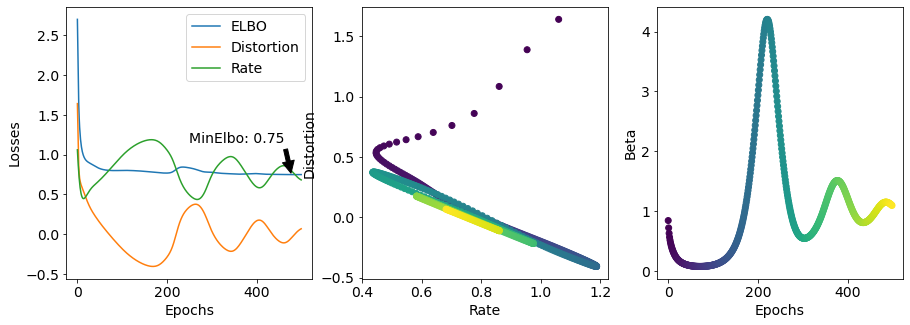

In [17]:
fig,ax = training_plots(lVec,dVec,rVec,bVec)
#fig.savefig("beta1_training.pdf")

In [18]:
min(dVec)

-0.40724761962890627

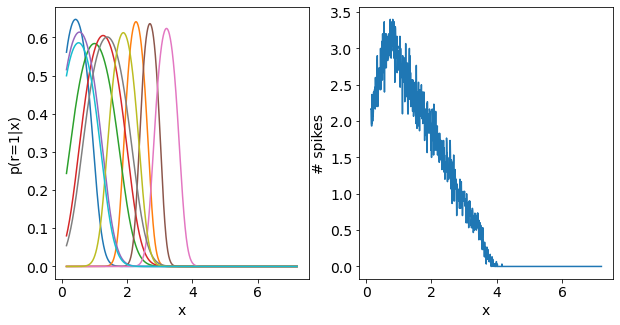

In [19]:
fig,axs = encoder_plots(enc,x_fine)
#fig.savefig("beta1_encoder.pdf")

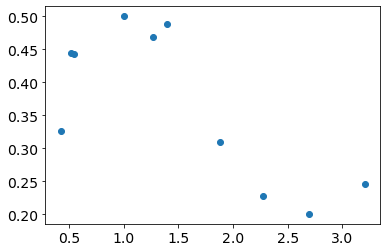

In [20]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))

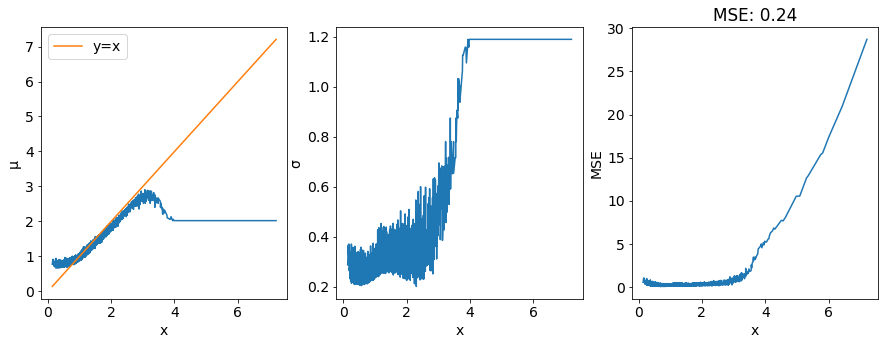

In [21]:
fig,axs = decoder_plots(enc,dec,x_sorted)
#fig.savefig("beta1_decoder.pdf")

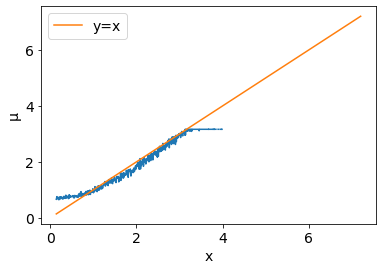

In [22]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')


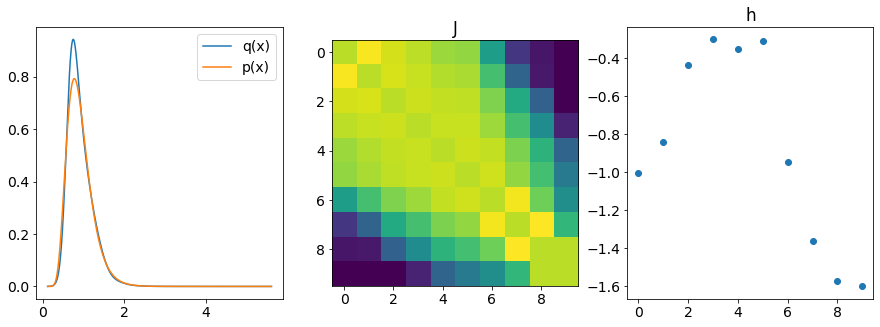

In [10]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
#fig.savefig("beta1_gm.pdf")

In [11]:
h =torch.histogram(x_samples)

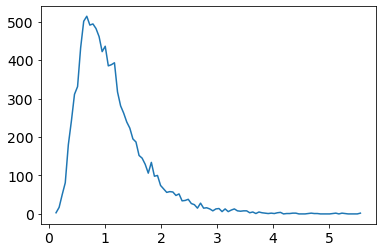

In [12]:
plt.plot(h.bin_edges[0:-1],h.hist)

In [13]:
q.h

Parameter containing:
tensor([[-0.4349, -1.3636, -0.2991, -0.3484, -1.0055, -1.5723, -1.6025, -0.3095,
         -0.9477, -0.8422]], requires_grad=True)

In [14]:
t = 1
for i in range(5):
    t *=(i+1)

In [108]:
t

120